In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from src.features import build_features
from src.models import predict_model

import warnings

warnings.filterwarnings('ignore')
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
DIAGS_MAS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I350",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J398",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J90X",
    "J91X",
    "J931",
    "J955",
    "J980",
    "M348",
    "Q211",
    "Q231",
    "Q676",
    "T820",
    "T821",
    "Z450",
]

In [4]:
# Lee la base de datos
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")

# Crea columna de fecha en datetime
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# Elimina columnas redundantes
egresos_torax = egresos_torax.drop(
    columns=[
        "ANO_EGRESO",
        "MES_EGRESO",
        "DIA_EGRESO",
        "ESTABLECIMIENTO_SALUD",
        "GLOSA_ESTABLECIMIENTO_SALUD",
    ]
).sort_values("FECHA_EGRESO")

# Elimina el anio 2020, debido a que es anomalo (Pandemia COVID)
egresos_torax = egresos_torax.query("FECHA_EGRESO < '2020-01-01'")

# Elige la fecha como indice de los datos
egresos_torax = egresos_torax.set_index("FECHA_EGRESO")

# Filtra los egresos de los diags mas relevantes
egresos_torax_mas_relevantes = egresos_torax.query("DIAG1.isin(@DIAGS_MAS_RELEVANTES)")

# Forecasting Multivariado

En este apartado se quiere realizar un modelo predicitvo que tome en cuenta cada uno de los diagnósticos distintos que existen en el INT. Para esto, se realizará un modelo de previsión multivariado, donde cada uno de las variables será uno de los diagnósticos.

In [5]:
# Transforma los egresos a formato long con cada fecha rellenada
df_multivariado = (
    (
        pd.pivot_table(
            egresos_torax.reset_index(),
            index="FECHA_EGRESO",
            values="n_egresos",
            columns="DIAG1",
            fill_value=0,
            aggfunc="sum",
        )
        .resample("M")
        .sum()
    )
    .reset_index()
    .melt(id_vars="FECHA_EGRESO", value_name="n_egresos")
    .sort_values(["FECHA_EGRESO", "DIAG1"])
)

# Transforma los egresos a formato long con cada fecha rellenada
df_relevantes_multivariado = (
    (
        pd.pivot_table(
            egresos_torax_mas_relevantes.reset_index(),
            index="FECHA_EGRESO",
            values="n_egresos",
            columns="DIAG1",
            fill_value=0,
            aggfunc="sum",
        )
        .resample("M")
        .sum()
    )
    .reset_index()
    .melt(id_vars="FECHA_EGRESO", value_name="n_egresos")
    .sort_values(["FECHA_EGRESO", "DIAG1"])
)

display(df_relevantes_multivariado)

,FECHA_EGRESO,DIAG1,n_egresos
0,2001-01-31,C33X,0
228,2001-01-31,C340,0
456,2001-01-31,C341,0
684,2001-01-31,C342,0
912,2001-01-31,C343,0
...,...,...,...
9347,2019-12-31,Q231,0
9575,2019-12-31,Q676,0
9803,2019-12-31,T820,5
10031,2019-12-31,T821,4


## Separar en train y test

In [6]:
CORTE_TEST = "2019-01-01"

# Separa en train y test para cada diagnostico distinto
train_multivariable = df_multivariado[df_multivariado["FECHA_EGRESO"] < CORTE_TEST].copy()
test_multivariable = df_multivariado[df_multivariado["FECHA_EGRESO"] >= CORTE_TEST].copy()

metricas = {"MAE": mean_absolute_error, "WMAPE": predict_model.wmape}

Como predicción inicial, haremos un modelo que prediga los egresos del próximo mes. Esta variable sera nuestra variable y.

## Preprocesamiento de datos

El preprocesamiento consistirá en:

- Crear la variable y a predecir. En este caso, serán los egresos del próximo mes para cada uno de los diagnósticos.
- Creas las variables X a utilizar:
    - Varible de lag 1 (valores del mes anterior)
    - Diferencia con el mes anterior
    - Promedio rolling de 4 meses
    - Variables relacionadas a la fecha

In [7]:
# Preprocesa train y test
train_multivariable = build_features.preprocesar_egresos_multivariado(train_multivariable)
test_multivariable = build_features.preprocesar_egresos_multivariado(test_multivariable)

FEATURES = [
    "n_egresos",
    "lag_1",
    "diff_1",
    "mean_4",
    "quarter",
    "month",
    "year",
    "season",
    "is_leap_year",
    "is_quarter_start",
    "is_quarter_end",
    "days_in_month",
    "holidays_per_month",
    "weekends_per_month",
    "business_days_per_month",
]

# Imputa valores NaNs para los lag, diff y mean
imputer = SimpleImputer()
X_train_multivariable = imputer.fit_transform(train_multivariable[FEATURES])
y_train_multivariable = train_multivariable["n_egresos_proximo_mes"]


X_test_multivariable = imputer.transform(test_multivariable[FEATURES])
y_test_multivariable = test_multivariable["n_egresos_proximo_mes"]

In [8]:
print(f"Los datos a utilizar en train son: {X_train_multivariable.shape} - "
      f"{y_train_multivariable.shape}")

print(f"Los datos a utilizar en test son: {X_test_multivariable.shape} - "
      f"{y_test_multivariable.shape}")

Los datos a utilizar en train son: (264020, 15) - (264020,)
Los datos a utilizar en test son: (13508, 15) - (13508,)


## Entrenamiento de modelos

In [9]:
# Entrena modelo
xgb_multivariable = XGBRegressor(
    colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8
)
xgb_multivariable.fit(X_train_multivariable, y_train_multivariable)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Train
MAE: 0.19
WMAPE: 0.57

Test
MAE: 0.24
WMAPE: 0.66



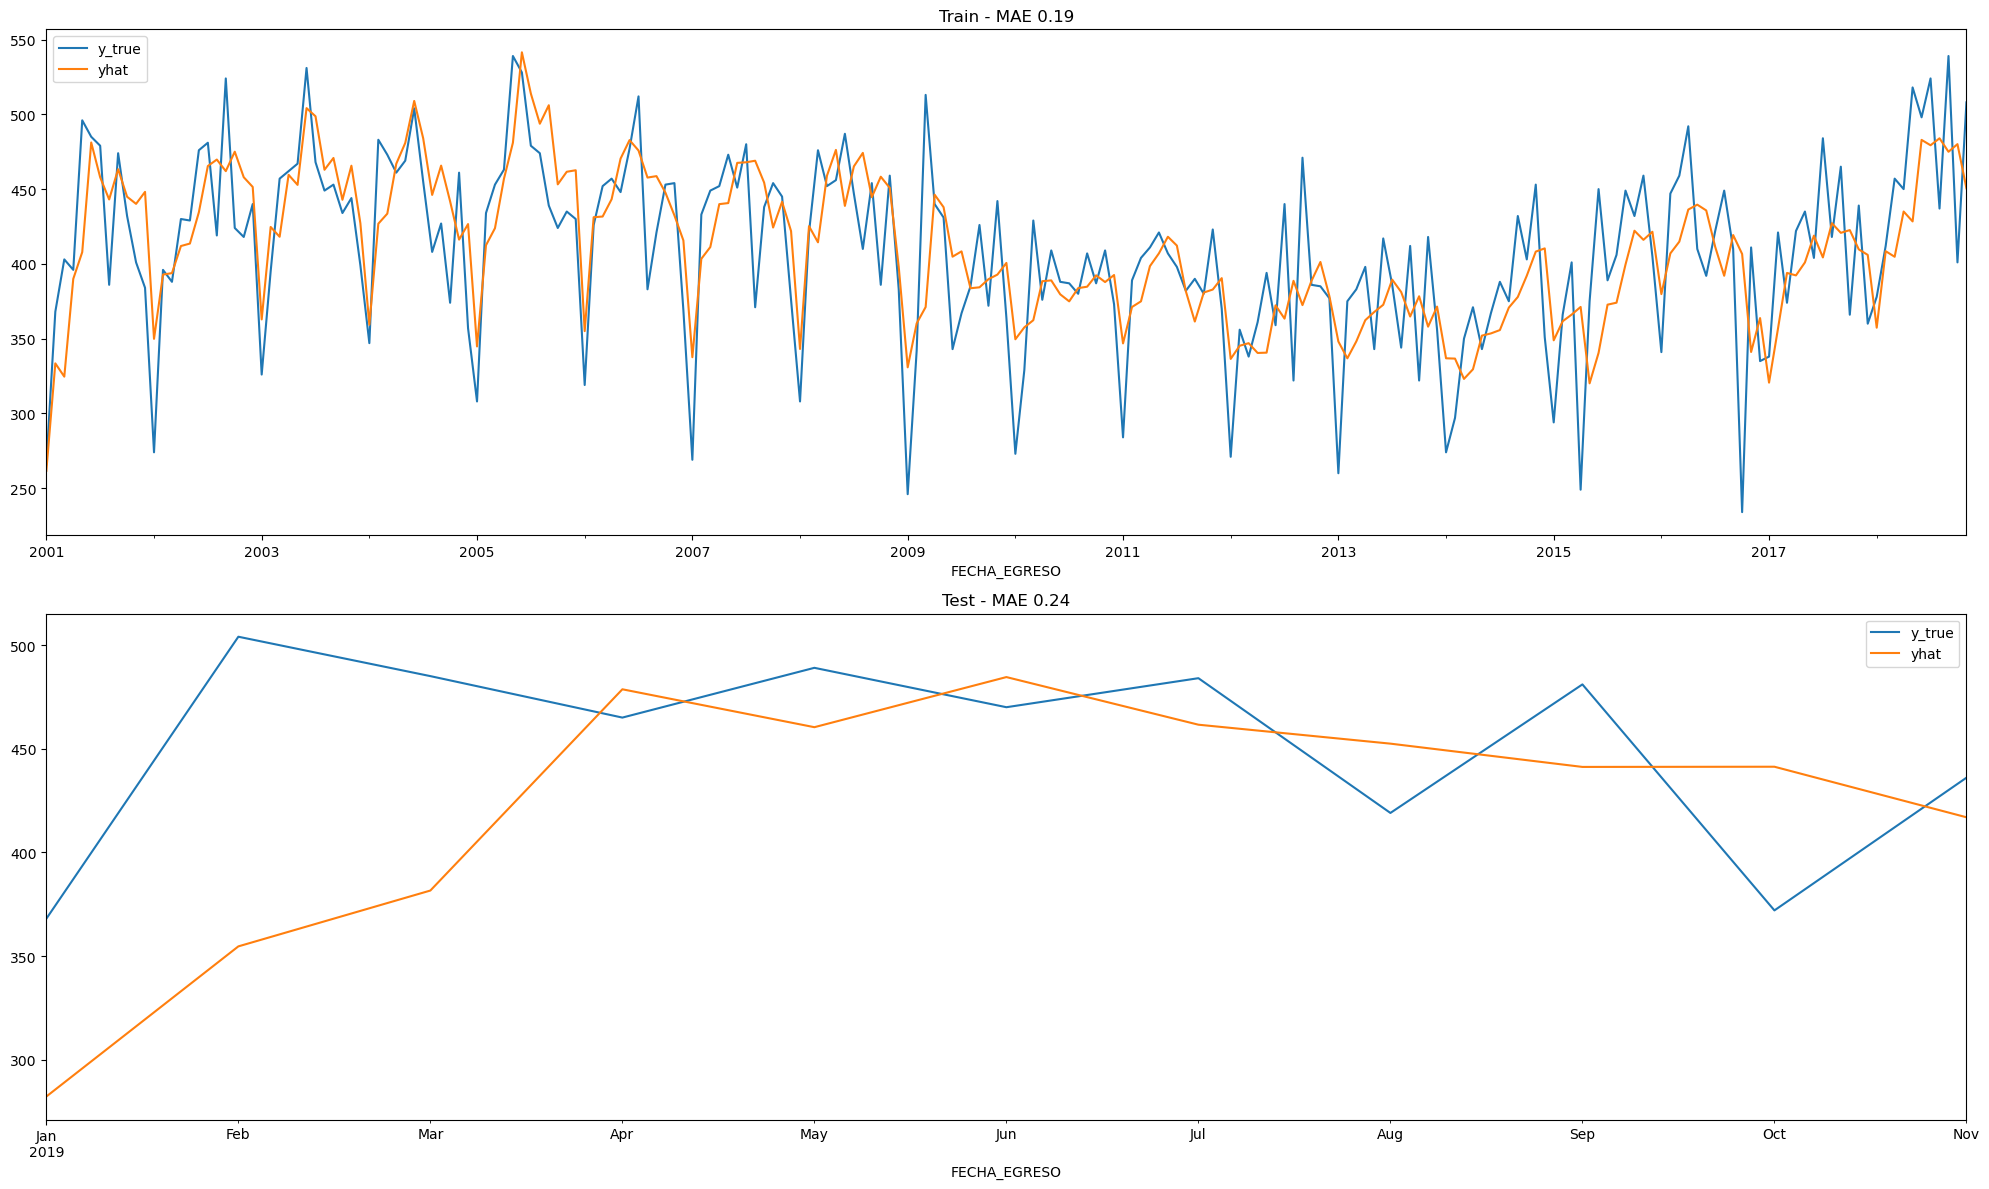

In [22]:
# Predice en conjunto de entrenamiento y testeo
yhat_train_xgb_multivariable = xgb_multivariable.predict(X_train_multivariable)
yhat_test_xgb_multivariable = xgb_multivariable.predict(X_test_multivariable)

# Reporta desmpeno en train y test
resultados_xgb_multivariable = (
    predict_model.evaluar_desempeno_train_y_test_serie_tiempo_multivariada(
        train_multivariable.index,
        y_train_multivariable,
        yhat_train_xgb_multivariable,
        train_multivariable["DIAG1"],
        test_multivariable.index,
        y_test_multivariable,
        yhat_test_xgb_multivariable,
        test_multivariable["DIAG1"],
        metricas,
    )
)